In [1]:
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
from collections import OrderedDict
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import HTML, display
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [2]:
# make figures appear large 
plt.rcParams['figure.figsize'] = [20, 5]

Just stuff for interactive displays. Run this next cell **BEFORE** running the following code

In [3]:
input_form = """
<div style="border:solid navy; padding:20px;">
<input type="file" id="file_selector" name="files[]"/>
<output id="list"></output>
</div>
"""

javascript = """
<script type="text/Javascript">
  function handleFileSelect(evt) {
    var kernel = IPython.notebook.kernel;
    var files = evt.target.files; // FileList object
    console.log('Executing orig')
    console.log(files)
    // files is a FileList of File objects. List some properties.
    var output = [];
    var f = files[0]
    output.push('<li><strong>', escape(f.name), '</strong> (', f.type || 'n/a', ') - ',
                  f.size, ' bytes, last modified: ',
                  f.lastModifiedDate ? f.lastModifiedDate.toLocaleDateString() : 'n/a',
                  '</_Mli>');
    document.getElementById('list').innerHTML = '<ul>' + output.join('') + '</ul>';
    var command = 'fname = "' + f.name + '"'
    console.log(command)
    kernel.execute(command);
  }

  document.getElementById('file_selector').addEventListener('change', handleFileSelect, false);
</script>
"""

def file_selector():
    display(HTML(input_form + javascript))

#########################################################################################################
sheetName = 'SELECT SHEET'
sheetSelector = widgets.Dropdown(options=[],description='Sheet name: ',disabled=False)
df = None # will be updated in handler call
def dropdown_handler(change):
    global sheetName
    global df
    global fname
    sheetName = change.new
    # automatically create dataframe with selection, update global
    df = pd.read_excel(io=fname,sheet_name=sheetName)

def sheet_selector(sheetnames):
    sheetSelector.options = sheetnames
    sheetSelector.observe(dropdown_handler, names='value')
    display(sheetSelector)
#########################################################################################################
frameName = 'Unnamed: 1'
dataName = 'Unnamed: 7'

frameSelector = widgets.Dropdown(options=[], description='Frames:',disabled=False)
dataSelector = widgets.Dropdown(options=[], description='Data:',disabled=False)

def frame_handler(change):
    global frameName
    frameName = change.new
def data_handler(change):
    global dataName
    dataName = change.new
    
def frame_selector(colnames):
    frameSelector.options=colnames
    frameSelector.observe(frame_handler,names='value')
    display(frameSelector)
    
def data_selector(colnames):
    dataSelector.options=colnames
    dataSelector.observe(data_handler,names='value')
    display(dataSelector)

**Helper functions for analysis and interactive, realtime plotting.**

This cell **MUST** be run once before continuing

In [4]:
def deltaFoverF(xs, ys):
    '''Gets the deltaF/F info
    Arguments:
    ----------
    xs : pandas.core.series.Series
        column from the dataframe representing frames
    ys : pandas.core.series.Series
        column from the dataframe containing data

    Returns:
    --------
    Fmin : float
        minimum value of fluorescence in ys
    xs : ndarray
        fixed array of frames, of same length as deltaF
    deltaF : ndarray
        numpy array with deltaF/F data from ys
    idx : ndarray
        boolean array with indices of valid (non-NaN) data
        in xs and ys
    '''
    validRange = xs.count()
    xs = xs[:validRange].to_numpy()
    ys = ys[:validRange].to_numpy()
    Fmin = np.min(ys)
    if Fmin == 0.0: print("WARNING - Fmin is zero")
    deltaF = np.fromiter(((i-Fmin)/Fmin for i in ys),float)
    idx = np.isfinite(xs) & np.isfinite(deltaF)
    return Fmin, xs[idx], deltaF[idx], idx

peaks = []
prominences = []
contour_heights = []
results_half = []
results_full = []

def update(h=0.2, w=5, wl=500):
    global peaks
    global prominences
    global contour_heights
    global results_half
    global results_full
    peaks, _ = find_peaks(deltaF[idx], height=h, width=w)
    prominences = peak_prominences(deltaF[idx], peaks, wlen=wl)
    contour_heights = deltaF[peaks] - prominences
    results_half = peak_widths(deltaF, peaks, prominence_data=prominences, rel_height=0.5)
    results_full = peak_widths(deltaF, peaks, prominence_data=prominences, rel_height=1)
    ax.clear()
    ax.plot(xs,deltaF)
    ax.plot(peaks,deltaF[peaks],'x')
    ax.vlines(x=peaks, ymin=contour_heights[0], ymax=deltaF[peaks], colors='red')
    ax.hlines(*results_half[1:], color="C2")
    ax.hlines(*results_full[1:], color="C3")
    ax.plot(np.zeros_like(xs), "--", color="gray")

# --------------------------------------------------------------
# MAIN ANALYSIS CODE
# --------------------------------------------------------------

**Open file to analyze.** 

Run the cell, then use the button to select a file. Once the cell has been run, it does not need to be re-run to select a new file.

In [5]:
file_selector()

**Run this next cell to get a `{sheetname : dataframe}` dictionary and display a dropdown for selecting the sheet you want to study.**

This cell **MUST BE** re-run every time you open a new file, but **not** if you just want to choose a new sheet to analyze.

In [6]:
xl = pd.ExcelFile(fname)
sheetDict = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}
sheet_selector(list(sheetDict.keys()))

Dropdown(description='Sheet name: ', options=('Bicc 1', 'Bicc 2', '4AP 1', '4AP 2', '4AP 3', 'Control 1', 'Con…

**Run this next cell to get a dropdown list of the available columns to analyze.**

If you changed the file, you **will** have to re-run this cell. Otherwise, you can just use the dropdown to select new frame/data columns if you're analyzing the same sheet.

In [7]:
frame_selector(df.keys().to_list())
data_selector(df.keys().to_list())

Dropdown(description='Frames:', options=('Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',…

Dropdown(description='Data:', options=('Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', '…

## Run the following cell once to begin interactive plotting, after selecting file + sheet + frame + data

<IPython.core.display.Javascript object>


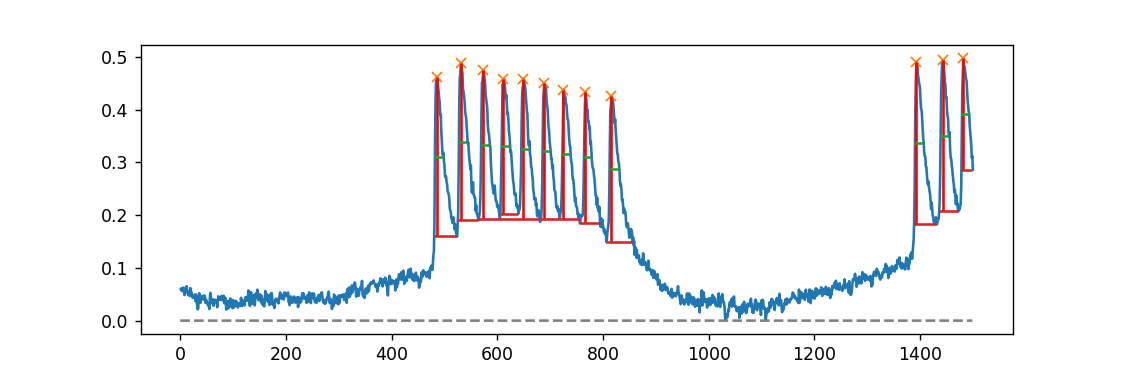

interactive(children=(FloatSlider(value=0.2, description='h', max=1.0, min=0.01, step=0.01), FloatSlider(value…

In [12]:
%matplotlib notebook
Fmin, xs, deltaF, idx = deltaFoverF(df[frameName],df[dataName])
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,1,1)
interact(update,
         h=widgets.FloatSlider(value=0.2,min=0.01,max=1.0,step=0.01),
         w=widgets.FloatSlider(value=5,min=1,max=100,step=1),
         wl=widgets.FloatSlider(value=100,min=2,max=1000,step=1));

# outputted data 

**Peak Information:**
* `peaks` - numpy array, stores time (frame) of peak
* `len(peaks)` - number of peaks

In [16]:
peaks

array([ 668,  726, 1386, 1446, 2052, 2110, 2691, 2753, 3553, 3627])

In [17]:
len(peaks)

10

**Peak height and width info:**
* `results_full`
* `results_half`

Both are the peak width and height information for the peaks @ full and half width, respectively. 

* `widths` : ndarray
    * The widths for each peak in samples.
* `width_heights` : ndarray
    * The height of the contour lines at which the `widths` where evaluated.
* `left_ips`, `right_ips` : ndarray
    * Interpolated positions of left and right intersection points of a horizontal line at the respective evaluation height.

Here is the full tuple of information:

In [18]:
results_full

(array([ 58.14455084, 267.96997691,  44.32038032, 240.99022346,
         51.74629574, 265.94480519,  47.68903535, 333.77156398,
        101.2642527 , 277.94407159]),
 array([0.08324775, 0.04996711, 0.06077986, 0.03828889, 0.05187117,
        0.03138812, 0.04770532, 0.02558362, 0.0366964 , 0.01525555]),
 array([ 660.85544916,  644.03002309, 1382.67961968, 1355.00977654,
        2045.25370426, 2027.05519481, 2684.31096465, 2555.        ,
        3498.7357473 , 3487.        ]),
 array([ 719.        ,  912.        , 1427.        , 1596.        ,
        2097.        , 2293.        , 2732.        , 2888.77156398,
        3600.        , 3764.94407159]))

The first element is the width of each peak (in frames):

In [20]:
results_full[0]

array([ 58.14455084, 267.96997691,  44.32038032, 240.99022346,
        51.74629574, 265.94480519,  47.68903535, 333.77156398,
       101.2642527 , 277.94407159])

The second element is the width heights (in $\Delta F/F$):

In [21]:
results_full[1]

array([0.08324775, 0.04996711, 0.06077986, 0.03828889, 0.05187117,
       0.03138812, 0.04770532, 0.02558362, 0.0366964 , 0.01525555])

The 3rd and 4th elements of `results_full` and `results_half` are the left and right ends, respectively, of the peak width. 

To show how this all works, let's look at peaks 1 and 2:

In [13]:
def peakInfo(peakNumber):
    assert(peakNumber < len(peaks))
    peakLoc = peaks[peakNumber-1]
    peakWidth = results_full[0][peakNumber-1]
    peakHeight = results_full[1][peakNumber-1]
    peakStart = results_full[2][peakNumber-1]
    peakEnd = results_full[3][peakNumber-1]
    print('Peak #{}\n\t is located at frame {},\n\t has width of {} frames,\n\t height of {},\n\t and starts and ends at frames ({},{})'.format(peakNumber,peakLoc,peakWidth,peakHeight,peakStart,peakEnd))
    print('check: peakEnd-peakStart\n\t = {}-{}\n\t = {}'.format(peakEnd,peakStart,peakEnd-peakStart))
    assert(peakWidth==peakEnd-peakStart)

In [14]:
for i in range(0,len(peaks)):
    peakInfo(i)

Peak #0
	 is located at frame 1481,
	 has width of 21.702876984126988 frames,
	 height of 0.28632769422088744,
	 and starts and ends at frames (1477.297123015873,1499.0)
check: peakEnd-peakStart
	 = 1499.0-1477.297123015873
	 = 21.702876984126988
Peak #1
	 is located at frame 485,
	 has width of 43.42224362060665 frames,
	 height of 0.1599521340247308,
	 and starts and ends at frames (479.57775637939335,523.0)
check: peakEnd-peakStart
	 = 523.0-479.57775637939335
	 = 43.42224362060665
Peak #2
	 is located at frame 531,
	 has width of 39.598974358974374 frames,
	 height of 0.19064267110912975,
	 and starts and ends at frames (524.4010256410256,564.0)
check: peakEnd-peakStart
	 = 564.0-524.4010256410256
	 = 39.598974358974374
Peak #3
	 is located at frame 573,
	 has width of 39.685131195335316 frames,
	 height of 0.19317675215279567,
	 and starts and ends at frames (564.3148688046647,604.0)
check: peakEnd-peakStart
	 = 604.0-564.3148688046647
	 = 39.685131195335316
Peak #4
	 is located a

# MATPLOTLIB INTERACTIVITY TEST

<IPython.core.display.Javascript object>


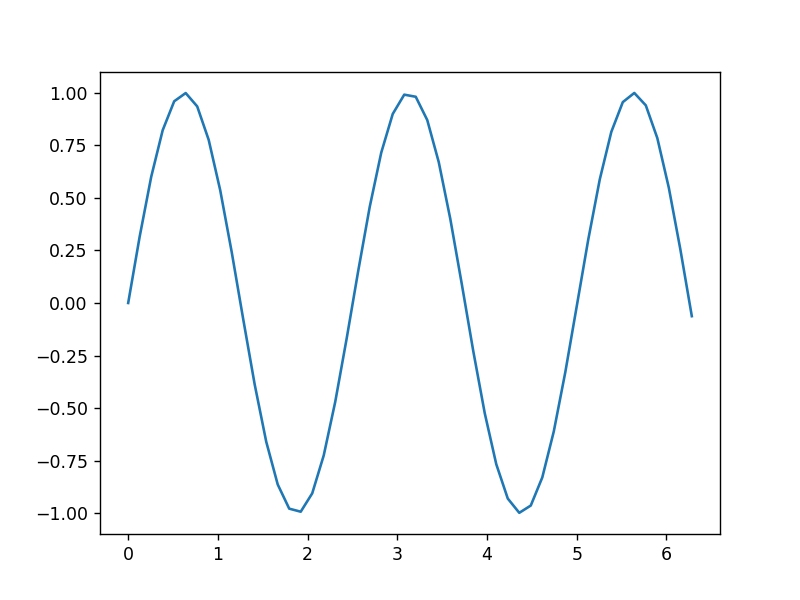

interactive(children=(FloatSlider(value=0.01, description='w', max=10.0, min=0.01, step=0.01), Output()), _dom…

In [14]:
%matplotlib notebook

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update, w=widgets.FloatSlider(min=0.01,max=10.0,step=0.01),);